# Setup

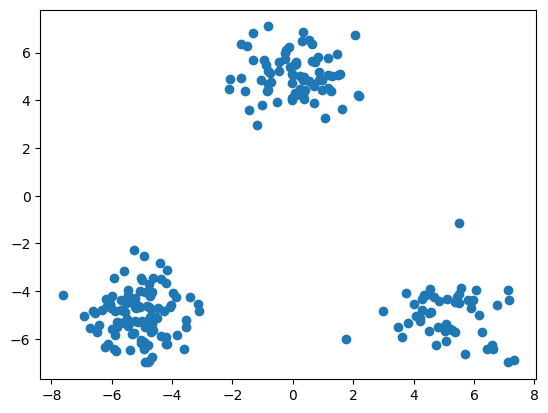

In [ ]:
import numpy as np
import matplotlib as mpl
import pylab as plt
from scipy.stats import multivariate_normal

def get_data():
    np.random.seed(42)
    # training data
    x1 = np.random.normal(size=(100, 2))
    x1 += np.array([-5, -5])
    x2 = np.random.normal(size=(50, 2))
    x2 += np.array([5, -5])
    x3 = np.random.normal(size=(75, 2))
    x3 += np.array([0, 5])
    X = np.vstack((x1, x2, x3))
    return X

X = get_data()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# **Gaussian Mixture Models**
In this notebook, we will look at density modeling with *Gaussian mixture models* (GMMs), which describe the density of a data sample $\boldsymbol{x} \in \mathbb{R}^D$ as
$$
p(\boldsymbol x) = \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\, \text{ with } \boldsymbol{\mu}_k \in \mathbb{R}^D\,,\, \boldsymbol{\Sigma}_k \in \mathbb{R}^{D \times D}\,,\, \pi_k \geq 0\,,\, \sum_{k=1}^K\pi_k = 1.
$$

The goal of this notebook is to get a better understanding of GMMs and to write some code for training GMMs using the *expectation-maximization-algorithm* (EM-algorithm) . We provide a code skeleton and mark the bits and pieces that you need to implement yourself.


We define the responsibilities (which are updated in the E-step), given the model parameters $\pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k$ as
$$
r_{nk} = \frac{\pi_k\mathcal N(\boldsymbol
          x_n|\boldsymbol\mu_k,\boldsymbol\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\boldsymbol
          x_n|\boldsymbol \mu_j,\boldsymbol\Sigma_j)}.
$$          
Given the responsibilities we just defined, we can update the model parameters in the M-step as follows:
\begin{align*}
\boldsymbol\mu_k^\text{new} &= \frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\boldsymbol x_n\,,\\
   \boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\boldsymbol x_n-\boldsymbol\mu_k)(\boldsymbol x_n-\boldsymbol\mu_k)^\top\,,\\
   \pi_k^\text{new} &= \frac{N_k}{N},
\end{align*}
where $$
N_k = \sum_{n=1}^N r_{nk}.
$$

> **Implement a GMM with the EM-algorithm**

In [ ]:
class GMM:
    """A GMM which is fitted through the EM-algorithm.

    Args:
        K (int): Number of components to be specified.
        n_iterations (int): Number of iterations of performing the EM algorithm.
        random_state (int): Random state to ensure reproducibility.

    """
    def __init__(self, K=3, n_iterations=10, random_state=5):
        self.K = K
        self.n_iterations = n_iterations
        self.random_state = random_state

    def density(self, X):
        """Computes component-wise densities of given samples.

        Args:
            X (array-like):  Samples whose densities are to be computed with shape (N, D).

        Returns:
            ndarray:  Computed densities per sample and component with shape (N, K).
        """
        # Stores density of each sample.
        densities = np.empty((len(X), self.K))

        # Iterate over each component.
        for k in range(self.K):
            # Compute mixture weighted densities for k-th component.
            densities_k = multivariate_normal(self.mu_[k], self.Sigma_[k]).pdf(X) * self.pi_[k]
            densities[:, k] = densities_k

        return densities

    def negative_log_likelihood(self, X):
        """Computes negative loglikelihood (NLL) for given samples.

        Args:
            X (array-like): Samples for which NLL is to be computed with shape (N, D).

        Returns:
            float: Computed negative log-likelihood.
        """
        # Compute negative log-likelihood.
        NLL = -np.sum(np.log(np.sum(self.density(X), axis=1)))
        return NLL

    def fit(self, X, y=None):
        """Fits the GMM by performing the EM-algorithm.

        Args:
            X (array-like): Training samples with shape (N, D).

        Returns:
            self: The fitted GMM.
        """
        # Transform to ndarray.
        X = np.array(X)

        # Store number of features.
        self.D_ = X.shape[1]

        # Set randomly inital parameters.
        self._set_inital_parameters()

        # Store negative log-likelihood value after each iteration.
        self._NLL_history = np.empty(self.n_iterations+1)

        # Compute initial negative log-likelihood value.
        self._NLL_history[0] = self.negative_log_likelihood(X)

        # Perform EM algorithm.
        for i in range(1, self.n_iterations+1):

            # E-step: Compute responsibilities.
            R = self._expectation(X)

            # M-step: Update GMM parameters.
            self._maximization(X, R)

            # Store updated parameters.
            self._mu_history[i] = self.mu_
            self._Sigma_history[i] = self.Sigma_
            self._pi_history[i] = self.pi_

            # Compute negative log-likelihood value.
            self._NLL_history[i] = self.negative_log_likelihood(X)

        return self

    def predict(self, X):
        """Predicts components with highest responsibility per sample.

        Args:
            X (array-like): Samples whose most likely components are to be predicted with shape (N, D).


        Returns:
            ndarray:  Most likely components from which the samples were generated with shape (N).
        """
        y_components = self._expectation(X).argmax(axis=1)
        return y_components

    def predict_proba(self, X):
        """Predicts responsibilities of given samples.

        Args:
            X (array-like): Samples (N, D) whose responsibilities are to be computed.

        Returns:
            array-like: Computed responsibilities with shape (N, K).

        """
        R = self._expectation(X)
        return R

    def _set_inital_parameters(self):
        """ Initializes the parameters of the GMM randomly. """
        # Defines random state for reproducibility.
        random_state = np.random.RandomState(self.random_state)

        # Storage for GMM parameters.
        self.mu_ = np.empty((self.K, self.D_))
        self.Sigma_ = np.empty((self.K, self.D_, self.D_))
        self.pi_ = np.empty((self.K))

        # Iterate over components.
        for k in range(self.K):

            # Initialize mean vector for the k-th component.
            mu_k = random_state.normal(self.D_, scale=0.5)
            self.mu_[k] = mu_k

            # Initialize covariance maxtrix for the k-th component.
            Sigma_k = np.eye(self.D_)
            self.Sigma_[k] = Sigma_k

        # Initialize mixture weights for all components.
        self.pi_ = np.ones(self.K)/self.K

        # Store history of parameters which will be used for plotting.
        self._mu_history = np.empty((self.n_iterations+1, self.K, self.D_))
        self._mu_history[0] = self.mu_
        self._Sigma_history = np.empty((self.n_iterations+1, self.K, self.D_, self.D_))
        self._Sigma_history[0] = self.Sigma_
        self._pi_history = np.empty((self.n_iterations+1, self.K))
        self._pi_history[0] = self.pi_

    def _expectation(self, X):
        """Implements E-step by computing responsibilities.

        Args:
            X (array-like): Samples whose responsibilities are to be computed with shape (N, D).


        Returns:
            array-like: Computed responsibilities with shape (N, K).

        """
        R = self.density(X)
        row_sums = np.sum(R, axis=1, keepdims=True)
        R = R / row_sums
        return R

    def _maximization(self, X, R):
        """Implements M-step by updating GMM parameters.

        Args:
            X (array-like): Samples whose responsibilities are to be computed with shape (N, D).
            R (array-like): Responsibilities of samples with (N, K).

        """
        # Compute estimated number of samples per component.
        N_k = np.sum(R, axis=0) + 1e-8

        # Update mixture weights by normalizing N_k.
        self.pi_ = N_k/len(X)

        # Update mean vectors.
        self.mu_ = R.T @ X / N_k[:, np.newaxis]
        for k in range(self.K):

            # Update covariance matrix for the k-th component.
            diff = X - self.mu_[k]
            Sigma_k = np.dot(R[:, k] * diff.T, diff) / N_k[k]
            Sigma_k[::self.D_ + 1] += 1.e-8
            self.Sigma_[k] = Sigma_k

> **Plot the data and the density of the fitted GMM.** You can plot the density by using contour and the provided meshgrid.

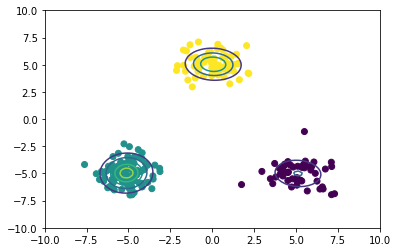

In [ ]:
X_mesh, Y_mesh = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
pos = np.column_stack([X_mesh.ravel(), Y_mesh.ravel()])

X = get_data()
gmm = GMM()
gmm.fit(X)

y_component = gmm.predict(X) # <-- SOLUTION
plt.scatter(X[:, 0], X[:, 1], c=y_component, zorder=3)

out = gmm.density(pos).sum(-1)
plt.contour(X_mesh, Y_mesh, out.reshape(X_mesh.shape),  alpha=1.0, zorder=4)
plt.show()

In [ ]:
plt.figure(figsize=(25, 5))
n_rows = 2
n_cols = int(np.ceil(len(gmm._mu_history) / n_rows))

for i_iter, (mu, Sigma, pi) in enumerate(zip(gmm._mu_history, gmm._Sigma_history, gmm._pi_history)):
    plt.subplot(n_rows, n_cols, 1+i_iter)
    gmm.mu_ = mu
    gmm.Sigma_ = Sigma
    gmm.pi_ = pi

    out = gmm.density(pos).sum(-1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.contour(X_mesh, Y_mesh, out.reshape(X_mesh.shape),  alpha=1.0, zorder=6)
plt.show()

#### **Questions:**

1. Can the NLL increase while performing the EM-Algorithm?
### SOLUTION ###   
   No, the EM-algorithm is guaranteed to obtain a non-negative decrease of the NLL in each iteration.   
   
2. Is the EM-algorithm for the GMM guaranteed to converge?

### SOLUTION ###   
   No, there can be cases, where in inifinite iterations the NLL is gradually decreased.   
   
3. How can we use the NLL as criterion for stopping the training of the GMM?

### SOLUTION ###   
   We could stop training, if the absolute difference between the NLLs of two successive iterations drops below a user-defined threshold (hyperparameter).    

In [ ]:
r1 = np.random.randn(5)
r2 = np.ones((5, 2))

r1.reshape(-1, 1).shape

(5, 1)

In [ ]:
N, K =
np.empty(N, K)